# 通し課題　Day1 →　Day2

　kaggleのデータセット「Kickstarter Projects」を用いてクラウドファンデイングが成功するか(state)を予測する。

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
import seaborn as sns
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.preprocessing import StandardScaler #標準化に関する関数
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


In [2]:
#データ読み込み
df_ks=pd.read_csv("ks-projects-201801.csv")
#df_ks=df_ks.iloc[0:10000,:]


In [3]:
#データ情報
df_ks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


欠損値は「name」と「usd pledged」のみ

In [4]:
#データ情報
df_ks.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


各列の意味を確認
- ID：個別ID
- name:名前
- category：詳細カテゴリー
- main_category：カテゴリー
- currency：通貨
- deadline：締め切りの日付
- goal：目標額
- launched：開始日
- pledged：集まった額
- state：状態
- backers：支援者数
- country：国
- usd pledged：アメリカドル換算の集計額
- usd_pledged_real：アメリカドル換算の集計額(fixerAPI換算)
- usd_goal_real：アメリカドル換算の目標額(fixerAPI換算)

In [5]:
#予測に使用しない「ID]や[name]列を削除
df_ks_pre=df_ks.drop(columns=["ID","name"])
#開始後に値が決定する列を削除
df_ks_pre=df_ks_pre.drop(columns=["pledged","backers","usd pledged","usd_pledged_real"])
#意味が重複する列を削除
df_ks_pre=df_ks_pre.drop(columns=["goal"])

In [6]:
#不要な列削除後のデータ情報
df_ks_pre.head()

,category,main_category,currency,deadline,launched,state,country,usd_goal_real
0,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,failed,GB,1533.95
1,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,failed,US,30000.00
2,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,failed,US,45000.00
3,Music,Music,USD,2012-04-16,2012-03-17 03:24:11,failed,US,5000.00
4,Film & Video,Film & Video,USD,2015-08-29,2015-07-04 08:35:03,canceled,US,19500.00


In [7]:
#欠損値確認
df_ks_pre.isnull().sum()

category         0
main_category    0
currency         0
deadline         0
launched         0
state            0
country          0
usd_goal_real    0
dtype: int64

欠損値なし

In [8]:
#カテゴリ変数と思われる項目の値を確認
print(df_ks_pre["state"].value_counts())
print(df_ks_pre["category"].value_counts())
print(df_ks_pre["main_category"].value_counts())
print(df_ks_pre["currency"].value_counts())
print(df_ks_pre["country"].value_counts())

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64
Product Design       22314
Documentary          16139
Music                15727
Tabletop Games       14180
Shorts               12357
Video Games          11830
Food                 11493
Film & Video         10108
Fiction               9169
Fashion               8554
Nonfiction            8318
Art                   8253
Apparel               7166
Theater               7057
Technology            6930
Rock                  6758
Children's Books      6756
Apps                  6345
Publishing            6018
Webseries             5762
Photography           5752
Indie Rock            5657
Narrative Film        5188
Web                   5153
Comics                4996
Crafts                4664
Country & Folk        4451
Design                4199
Hip-Hop               3912
Hardware              3663
                     ...  
Couture    

In [9]:
#質的変数を変換
enc=OneHotEncoder(sparse=False)

#'category','main_category','currency','country'
enc.fit(df_ks_pre[['category','main_category','currency','country']].values.reshape(-1,1))
#print(enc.categories_)
#print(enc.categories_[0])
X_trans = enc.transform(df_ks_pre[['category','main_category','currency','country']].values.reshape(-1,1))

df_ks_trans =pd.DataFrame(X_trans,columns=enc.categories_[0])

df_ks_trans=pd.concat([df_ks_pre,df_ks_trans],axis=1)

print(df_ks_trans.head())


         category main_category currency    deadline             launched  \
0          Poetry    Publishing      GBP  2015-10-09  2015-08-11 12:12:28   
1  Narrative Film  Film & Video      USD  2017-11-01  2017-09-02 04:43:57   
2  Narrative Film  Film & Video      USD  2013-02-26  2013-01-12 00:20:50   
3           Music         Music      USD  2012-04-16  2012-03-17 03:24:11   
4    Film & Video  Film & Video      USD  2015-08-29  2015-07-04 08:35:03   

      state country  usd_goal_real  3D Printing   AT  ...  Wearables  Weaving  \
0    failed      GB        1533.95          0.0  0.0  ...        0.0      0.0   
1    failed      US       30000.00          0.0  0.0  ...        0.0      0.0   
2    failed      US       45000.00          0.0  0.0  ...        0.0      0.0   
3    failed      US        5000.00          0.0  0.0  ...        0.0      0.0   
4  canceled      US       19500.00          0.0  0.0  ...        0.0      0.0   

   Web  Webcomics  Webseries  Woodworking  Worksho

In [10]:
#変換した質的変数の列を削除
df_ks_trans=df_ks_trans.drop(columns=['category','main_category','currency','country'])

df_ks_trans.head()

,deadline,launched,state,usd_goal_real,3D Printing,AT,AU,AUD,Academic,Accessories,...,Wearables,Weaving,Web,Webcomics,Webseries,Woodworking,Workshops,World Music,Young Adult,Zines
0,2015-10-09,2015-08-11 12:12:28,failed,1533.95,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017-11-01,2017-09-02 04:43:57,failed,30000.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-02-26,2013-01-12 00:20:50,failed,45000.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2012-04-16,2012-03-17 03:24:11,failed,5000.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015-08-29,2015-07-04 08:35:03,canceled,19500.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
#日付を期間に変換
df_ks_trans['period']=pd.to_datetime(df_ks_trans.loc[:,'deadline'],format='%Y-%m-%d')-pd.to_datetime(df_ks_trans.loc[:,'launched'],format='%Y-%m-%d %H:%M:%S')
df_ks_trans['period']=df_ks_trans['period'].dt.days

#変換した元の列を削除
df_ks_trans=df_ks_trans.drop(columns=['deadline','launched'])

df_ks_trans.head()

,state,usd_goal_real,3D Printing,AT,AU,AUD,Academic,Accessories,Action,Animals,...,Weaving,Web,Webcomics,Webseries,Woodworking,Workshops,World Music,Young Adult,Zines,period
0,failed,1533.95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.0
1,failed,30000.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0
2,failed,45000.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0
3,failed,5000.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0
4,canceled,19500.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0


In [12]:
#結果が出ているデータのみ抽出
df_ks_extra=df_ks_trans.loc[(df_ks_trans['state']=='successful') | (df_ks_trans['state']=='failed')]

#結果を数値に変換
df_ks_extra.loc[df_ks_extra['state']=='successful','state_num']=1
df_ks_extra.loc[df_ks_extra['state']=='failed','state_num']=0

#変換した元の列を削除
df_ks_extra=df_ks_extra.drop(columns=['state'])

#インデックス振り直し
df_ks_extra.reset_index(inplace = True)
df_ks_extra=df_ks_extra.drop(columns=['index'])

df_ks_extra.head()

C:\Users\mura\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\mura\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,usd_goal_real,3D Printing,AT,AU,AUD,Academic,Accessories,Action,Animals,Animation,...,Web,Webcomics,Webseries,Woodworking,Workshops,World Music,Young Adult,Zines,period,state_num
0,1533.95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.0,0.0
1,30000.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,0.0
2,45000.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0,0.0
3,5000.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0
4,50000.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,1.0


In [13]:
#基本統計量
print(df_ks_extra.describe())

       usd_goal_real    3D Printing             AT             AU  \
count   3.316750e+05  331675.000000  331675.000000  331675.000000   
mean    4.151000e+04       0.000494       0.000458       0.005201   
std     1.108930e+06       0.022231       0.021403       0.071929   
min     1.000000e-02       0.000000       0.000000       0.000000   
25%     2.000000e+03       0.000000       0.000000       0.000000   
50%     5.000000e+03       0.000000       0.000000       0.000000   
75%     1.500000e+04       0.000000       0.000000       0.000000   
max     1.663614e+08       1.000000       1.000000       1.000000   

                 AUD       Academic    Accessories         Action  \
count  331675.000000  331675.000000  331675.000000  331675.000000   
mean        0.005204       0.000591       0.002174       0.000458   
std         0.071950       0.024302       0.046574       0.021403   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.0000

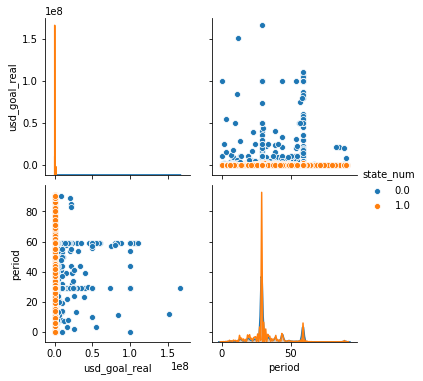

In [14]:
# 散布図行列
sns.pairplot(df_ks_extra.loc[:,["usd_goal_real","state_num","period"]],hue="state_num")

In [15]:
# 相関係数を確認
df_ks_extra.corr()

,usd_goal_real,3D Printing,AT,AU,AUD,Academic,Accessories,Action,Animals,Animation,...,Web,Webcomics,Webseries,Woodworking,Workshops,World Music,Young Adult,Zines,period,state_num
usd_goal_real,1.000000,-0.000495,-0.000154,-0.001175,-0.001266,0.000059,-0.001017,0.000475,-0.000337,-0.000920,...,-0.001058,-0.000277,0.003940,-0.000087,-0.000177,-0.000817,-0.000441,-0.000321,0.021607,-0.023735
3D Printing,-0.000495,1.000000,-0.000476,-0.001608,-0.001609,-0.000541,-0.001038,-0.000476,-0.000281,-0.000888,...,-0.001284,-0.000444,-0.001364,-0.000618,-0.000228,-0.000808,-0.000532,-0.000332,0.001060,0.002422
AT,-0.000154,-0.000476,1.000000,-0.001548,-0.001549,-0.000521,-0.000999,-0.000458,-0.000271,-0.000855,...,-0.001236,-0.000427,-0.001313,-0.000595,-0.000220,-0.000778,-0.000513,-0.000320,0.000863,0.000175
AU,-0.001175,-0.001608,-0.001548,1.000000,-0.005230,-0.001758,-0.003375,-0.001548,-0.000914,-0.002887,...,-0.004173,-0.001443,-0.004433,-0.002010,-0.000743,-0.002626,-0.001731,-0.001080,-0.000489,0.000368
AUD,-0.001266,-0.001609,-0.001549,-0.005230,1.000000,-0.001759,-0.003376,-0.001549,-0.000914,-0.002888,...,-0.004174,-0.001443,-0.004434,-0.002010,-0.000743,-0.002627,-0.001732,-0.001080,0.000652,0.000248
Academic,0.000059,-0.000541,-0.000521,-0.001758,-0.001759,1.000000,-0.001135,-0.000521,-0.000307,-0.000971,...,-0.001403,-0.000485,-0.001491,-0.000676,-0.000250,-0.000883,-0.000582,-0.000363,0.001316,-0.002569
Accessories,-0.001017,-0.001038,-0.000999,-0.003375,-0.003376,-0.001135,1.000000,-0.000999,-0.000590,-0.001864,...,-0.002694,-0.000931,-0.002862,-0.001297,-0.000479,-0.001695,-0.001117,-0.000697,-0.003496,-0.000554
Action,0.000475,-0.000476,-0.000458,-0.001548,-0.001549,-0.000521,-0.000999,1.000000,-0.000271,-0.000855,...,-0.001236,-0.000427,-0.001313,-0.000595,-0.000220,-0.000778,-0.000513,-0.000320,0.000353,-0.001260
Animals,-0.000337,-0.000281,-0.000271,-0.000914,-0.000914,-0.000307,-0.000590,-0.000271,1.000000,-0.000505,...,-0.000730,-0.000252,-0.000775,-0.000351,-0.000130,-0.000459,-0.000303,-0.000189,-0.001118,-0.000197
Animation,-0.000920,-0.000888,-0.000855,-0.002887,-0.002888,-0.000971,-0.001864,-0.000855,-0.000505,1.000000,...,-0.002304,-0.000797,-0.002448,-0.001110,-0.000410,-0.001450,-0.000956,-0.000597,0.005025,-0.002196


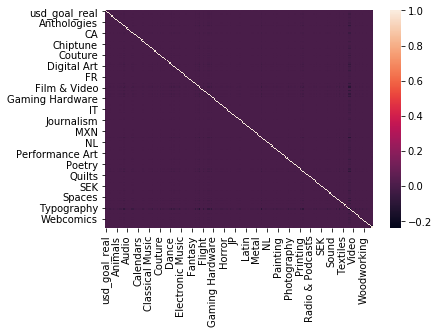

In [16]:
# 相関係数をヒートマップにして可視化
sns.heatmap(df_ks_extra.corr())
plt.show()

相関の強い変数は無さそう

#### Day2 交差検証、標準化

In [27]:
#説明変数と目的変数を設定
X, y = df_ks_extra.iloc[:,:-1].values, df_ks_extra["state_num"].values

# ホールドアウト法を実行
test_size = 0.2        # テストデータの割合
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) 

#学習用データを使って標準化
stdsc=StandardScaler()
X_train_stand=stdsc.fit_transform(X_train)
X_test_stand=stdsc.transform(X_test)

#標準化したデータを確認
df_train_std = pd.DataFrame(stdsc.transform(X_train), columns=df_ks_extra.iloc[:,:-1].columns)
print(df_train_std.describe())
df_test_std = pd.DataFrame(X_test_stand, columns=df_ks_extra.iloc[:,:-1].columns)
print(df_test_std.describe())


       usd_goal_real   3D Printing            AT            AU           AUD  \
count   2.653400e+05  2.653400e+05  2.653400e+05  2.653400e+05  2.653400e+05   
mean    3.591758e-16 -2.247101e-15 -5.908310e-15  2.440244e-15 -3.235335e-15   
std     1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00   
min    -3.926851e-02 -2.264537e-02 -2.135946e-02 -7.267313e-02 -7.209438e-02   
25%    -3.724932e-02 -2.264537e-02 -2.135946e-02 -7.267313e-02 -7.209438e-02   
50%    -3.422051e-02 -2.264537e-02 -2.135946e-02 -7.267313e-02 -7.209438e-02   
75%    -2.412449e-02 -2.264537e-02 -2.135946e-02 -7.267313e-02 -7.209438e-02   
max     1.528103e+02  4.415914e+01  4.681765e+01  1.376024e+01  1.387071e+01   

           Academic   Accessories        Action       Animals     Animation  \
count  2.653400e+05  2.653400e+05  2.653400e+05  2.653400e+05  2.653400e+05   
mean  -1.524959e-15 -4.404868e-15  3.280085e-15 -4.949824e-15 -2.160801e-15   
std    1.000002e+00  1.000002e+00  1.00000

#SVMでハイパーパラメータを適当に決めてみたが、学習が終わらないので以下は使用しない
```python
#SVM
#ハイパーパラメータ
C = 5
kernel = "rbf"
gamma = 1
#学習
clf=SVC(C=C, kernel=kernel, gamma=gamma)
clf.fit(X_train_stand,y_train)
#予測
y_est=clf.predict(X_test_stand)
```

#SVMでグリッドサーチでハイパーパラメータを決めてみたが、学習が終わらないので以下は使用しない
```python
parameters = {'kernel':['rbf','linear'], 'C':[1, 5]}
model = SVC(gamma="scale") # gamma=scaleにすると、gammaが自動で計算される
clf = GridSearchCV(model, parameters, cv=3,)
clf.fit(X_train_stand, y_train)
print(clf.best_params_, clf.best_score_)

# 最適パラメータを用いて識別する
clf2 = SVC(**clf.best_params_, gamma="scale") # gamma=scaleにすると、gammaが自動で計算される
clf2.fit(X_train_stand, y_train)
print("識別精度=",clf2.score(X_test_stand, y_test))

#予測
y_est=clf2.predict(X_test_stand)

#正答率
accuracy=accuracy_score(y_test,y_est)
print('正答率(Accuracy) = {:.3f}%'.format(100*accuracy))
    
#Precision,Recall,F1-score
precision,recall,f1_score,_=precision_recall_fscore_support(y_test,y_est)
print(precision)
print('適合率(Precision)={:.3f}%'.format(100*precision[1]))
print('再現率(Recall)={:.3f}%'.format(100*recall[1]))
print('F1値(F1-score)={:.3f}%'.format(100*f1_score[1]))

```

In [28]:
print("*****ロジスティック回帰学習*****")
clf_SGD=SGDClassifier(loss='log',penalty='none',max_iter=1000,
                 fit_intercept=True,random_state=1234,tol=1e-3)
clf_SGD.fit(X_train_stand,y_train)

print("予測")
y_est=clf_SGD.predict(X_test_stand)

#正答率
accuracy=accuracy_score(y_test,y_est)
print('正答率(Accuracy) = {:.3f}%'.format(100*accuracy))

#Precision,Recall,F1-score
precision,recall,f1_score,_=precision_recall_fscore_support(y_test,y_est)
print(precision)
print('適合率(Precision)={:.3f}%'.format(100*precision[1]))
print('再現率(Recall)={:.3f}%'.format(100*recall[1]))
print('F1値(F1-score)={:.3f}%'.format(100*f1_score[1]))

#予測値と正解のクロス集計
conf_mat=pd.DataFrame(confusion_matrix(y_test,y_est),
                     index=['正解=failed','正解=successful'],
                     columns=['予測=failed','予測=successful'])
print(conf_mat)


*****ロジスティック回帰学習*****
予測
正答率(Accuracy) = 60.971%
[0.6283483  0.52884848]
適合率(Precision)=52.885%
再現率(Recall)=24.700%
F1値(F1-score)=33.673%
               予測=failed  予測=successful
正解=failed          33873           5855
正解=successful      20035           6572


#### 交差検証

In [29]:
#説明変数と目的変数を設定
X, y = df_ks_extra.iloc[:,:-1].values, df_ks_extra.loc[:,"state_num"].values

#交差検証用にデータを分割
n_split = 5 #グループ数

#変数初期化
cross_svc_accuracy = 0
cross_SGD_accuracy = 0
split_num = 1

#テスト役を交代させながら学習と評価

for train_idx, test_idx in KFold(n_splits=n_split,shuffle=True,random_state=1234).split(X, y):
    #print("train_idx:", train_idx, "test_idx:", test_idx)

    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test,y_test=X[test_idx],y[test_idx] #テスト用データ
    
    #学習用データを使って標準化
    stdsc=StandardScaler()
    X_train_stand=stdsc.fit_transform(X_train)
    X_test_stand=stdsc.transform(X_test)

    #SVMは学習が終わらないので使用しない
    """
    C = 10
    kernel = "rbf"
    gamma = 1
    print("*****SVM学習*****")
    clf=SVC(C=C, kernel=kernel, gamma=gamma)
    clf.fit(X_train_stand,y_train)

    #予測
    print("予測")
    y_est=clf.predict(X_test_stand)

    #正答率
    accuracy=accuracy_score(y_test,y_est)
    print('正答率(Accuracy) = {:.3f}%'.format(100*accuracy))
    
    cross_svc_accuracy += accuracy
    
    #Precision,Recall,F1-score
    precision,recall,f1_score,_=precision_recall_fscore_support(y_test,y_est)
    print(precision)
    print('適合率(Precision)={:.3f}%'.format(100*precision[1]))
    print('再現率(Recall)={:.3f}%'.format(100*recall[1]))
    print('F1値(F1-score)={:.3f}%'.format(100*f1_score[1]))

    #予測値と正解のクロス集計
    #conf_mat=pd.DataFrame(confusion_matrix(y_test,y_est))
    conf_mat=pd.DataFrame(confusion_matrix(y_test,y_est),
                         index=['正解=failed','正解=successful'],
                         columns=['予測=failed','予測=successful'])
    print(conf_mat)
    """
    
    print("*****ロジスティック回帰学習*****")
    clf_SGD=SGDClassifier(loss='log',penalty='none',max_iter=1000,
                     fit_intercept=True,random_state=1234,tol=1e-3)
    clf_SGD.fit(X_train_stand,y_train)
    
    print("予測")
    y_est=clf_SGD.predict(X_test_stand)

    #正答率
    accuracy=accuracy_score(y_test,y_est)
    print('正答率(Accuracy) = {:.3f}%'.format(100*accuracy))

    cross_SGD_accuracy += accuracy
    
    #Precision,Recall,F1-score
    precision,recall,f1_score,_=precision_recall_fscore_support(y_test,y_est)
    print(precision)
    print('適合率(Precision)={:.3f}%'.format(100*precision[1]))
    print('再現率(Recall)={:.3f}%'.format(100*recall[1]))
    print('F1値(F1-score)={:.3f}%'.format(100*f1_score[1]))

    #予測値と正解のクロス集計
    conf_mat=pd.DataFrame(confusion_matrix(y_test,y_est),
                         index=['正解=failed','正解=successful'],
                         columns=['予測=failed','予測=successful'])
    print(conf_mat)

    split_num += 1

#accuracyの平均値を最終的な正答率とする
#final_svc_accuracy = cross_svc_accuracy / n_split
final_SGD_accuracy = cross_SGD_accuracy / n_split
#print("Cross Validation svc accuracy = %s"%round(final_svc_accuracy, 3))
print("Cross Validation SGD accuracy = %s"%round(final_SGD_accuracy, 3))

*****ロジスティック回帰学習*****
予測
正答率(Accuracy) = 60.901%
[0.61804985 0.54236646]
適合率(Precision)=54.237%
再現率(Recall)=16.142%
F1値(F1-score)=24.880%
               予測=failed  予測=successful
正解=failed          36104           3624
正解=successful      22312           4295
*****ロジスティック回帰学習*****
予測
正答率(Accuracy) = 60.882%
[0.61539513 0.55944594]
適合率(Precision)=55.945%
再現率(Recall)=16.230%
F1値(F1-score)=25.161%
               予測=failed  予測=successful
正解=failed          36024           3435
正解=successful      22514           4362
*****ロジスティック回帰学習*****
予測
正答率(Accuracy) = 60.383%
[0.6256512  0.52174849]
適合率(Precision)=52.175%
再現率(Recall)=27.036%
F1値(F1-score)=35.617%
               予測=failed  予測=successful
正解=failed          32786           6663
正解=successful      19617           7269
*****ロジスティック回帰学習*****
予測
正答率(Accuracy) = 60.995%
[0.62651584 0.5373316 ]
適合率(Precision)=53.733%
再現率(Recall)=24.711%
F1値(F1-score)=33.853%
               予測=failed  予測=successful
正解=failed          33840           5701
正解=succe